In [ ]:
pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.9 MB/s eta 0:00:00


In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=1070e1d82f4356c76f3f0e4c4a85e5f8a89323ddfd1503ff225a0ffc0797192d
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy, f1_score, precision, recall, auroc
from pytorch_lightning.profilers import PyTorchProfiler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/JinWen_datasets/No_inv_smart_aug.zip;

Streaming output truncated to the last 5000 lines.
  inflating: No_inv_smart_aug/1218/1218_6_11.jpg  
  inflating: No_inv_smart_aug/1218/1218_3_0.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_3.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_1.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_0.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_2.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_0.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_2.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_3.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_1.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_5.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_7.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_6.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_4.jpg  
  inflating: No_inv_smart_aug/1218/1218_6_6.jpg  
  inflating: No_inv_smart_aug/1218/1218_8_9.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_4.jpg  
  inflating: No_inv_smart_aug/1218/1218_4_5.jpg  
  inflating: No_inv_smart_aug/1218/1218_8_8.jpg 

In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
path = '/content/No_inv_smart_aug'

In [ ]:
def train_val_split(dataset, val_size: float, batch_size: int, num_workers: int):
    train_idx = set(range(0, len(dataset)))
    
    val_idx = set(np.random.choice(len(train_idx), size=int(val_size*len(train_idx)), replace=False))
    val_data = Subset(dataset, list(val_idx))
    train_idx -= val_idx

    train_data = Subset(dataset, list(train_idx))

    dataset_sizes = {'train':len(train_data), 'val':len(val_data)}
    train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_data, val_data, dataset_sizes

In [ ]:
seed_everything(64)

transform = transforms.Compose([
        transforms.Resize([28, 28]),
        transforms.ToTensor()])

full_dataset = ImageFolder(path, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

train_dataloader, val_dataloader, dataset_sizes = train_val_split(full_dataset, val_size=0.2, batch_size=64, num_workers=2)

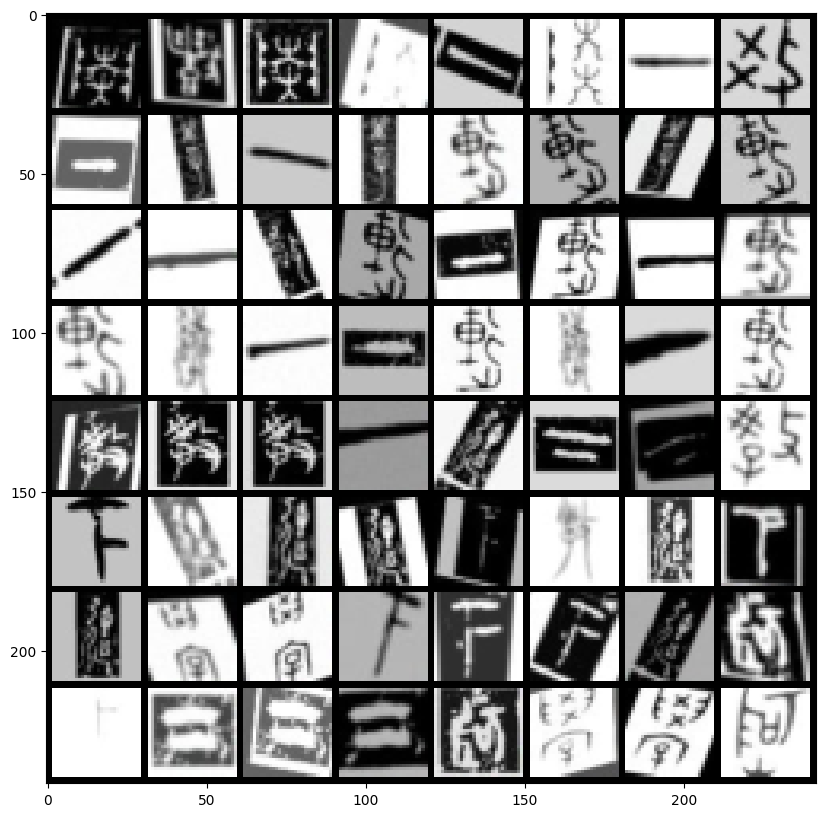

In [ ]:
seed_everything(64)

plt.figure(figsize=(15, 10))

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(val_dataloader))
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:
class MyModule(pl.LightningModule):
    def __init__(self,
                 model=torchvision.models.resnet18(num_classes=num_classes),
                 optimizer_instance=None,
                 lr=0.01,
                 momentum=0,
                 weight_decay=0,
                 scheduler=None):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.save_hyperparameters(ignore=['criterion', 'model'])

    def forward(self, x):
        self.model.eval()
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x)
        loss = self.criterion(preds, y)

        self.log('train_loss', loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x)
        loss = self.criterion(preds, y)

        f1 = f1_score(preds, y, task='multiclass', average='weighted', num_classes=self.num_classes)
        acc = accuracy(preds, y, task='multiclass', average='weighted', num_classes=self.num_classes)

        
        self.log('val_acc', acc)
        self.log('val_loss', loss)
        self.log('val_f1', f1)
        return loss

    def configure_optimizers(self):
        if self.hparams.momentum:
            optimizer = self.hparams.optimizer_instance(self.model.parameters(),
                                                lr=self.hparams.lr,
                                                momentum=self.hparams.momentum,
                                                weight_decay=self.hparams.weight_decay)
        else:
            optimizer = self.hparams.optimizer_instance(self.model.parameters(),
                                                lr=self.hparams.lr,
                                                weight_decay=self.hparams.weight_decay)
            
        if self.hparams.scheduler:
            self.hparams.scheduler = self.hparams.scheduler(optimizer, 5)
            return {'optimizer':optimizer, 'lr_scheduler':self.hparams.scheduler}
        return optimizer

In [ ]:
def easy_train(architecture, model, epochs, optimizer, lr, auto_lr=False, momentum=0, weight_decay=0, scheduler=None):
    seed_everything(64)
    wandb.finish()

    name = f'{architecture}_{optimizer.__name__}_lr={lr}' # _aLR={auto_lr}_L2={weight_decay}_moment={momentum}_sched={scheduler.__name__ if scheduler else None}
    config = {'architecture':architecture,
              'epochs':epochs,
              'lr':lr,
              'auto_lr':auto_lr,
              'momentum':momentum,
              'weight_decay':weight_decay,
              'scheduler':scheduler.__name__ if scheduler else None}

    wandb_logger = WandbLogger(project='baseline', name=name, config=config, log_model=True)
    checkpoint_callback = ModelCheckpoint(dirpath=f"/content/baseline/{name}", save_top_k=1, monitor="val_f1", mode="max", filename="{epoch:02d}-{val_accuracy:.2f}")

    module = MyModule(model=model,
                      optimizer_instance=optimizer,
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay,
                      scheduler=scheduler)

    profiler = PyTorchProfiler()
    
    if auto_lr:
        trainer = pl.Trainer(auto_lr_find=True, profiler=profiler, accelerator=None)
        trainer.tune(module, train_dataloader, val_dataloader)
    else:
        trainer = pl.Trainer(max_epochs=epochs, logger=wandb_logger, callbacks=[checkpoint_callback], accelerator='cuda', profiler=profiler)
        trainer.fit(module, train_dataloader, val_dataloader)

In [ ]:
easy_train('inv_resnet18',
           torchvision.models.resnet18(weights=None, num_classes=num_classes),
           epochs=10,
           lr=0.001,
           optimizer=torch.optim.Adam)

wandb: Currently logged in as: dushamishkin. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 12.8 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
12.8 M    Trainable params
0         Non-trainable params
12.8 M    Total params
51.394    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         8.64%       8.553ms        99.97%      98.951ms      49.475ms       0.000us         0.00%      15.841ms       7.920ms             2  
[pl][profile][Strategy]Sing

In [ ]:
easy_train('noinv_resnet18',
           torchvision.models.resnet18(weights=None, num_classes=num_classes),
           epochs=10,
           lr=0.001,
           optimizer=torch.optim.Adam)

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▇▇▄▃▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▆▇▇▇█████
val_f1,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
train_loss,0.06622
trainer/global_step,38119
val_acc,0.92839
val_f1,0.95714


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 12.8 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
12.8 M    Trainable params
0         Non-trainable params
12.8 M    Total params
51.394    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         4.63%       3.157ms        99.96%      68.171ms      34.086ms       0.000us         0.00%      13.880ms       6.940ms             2  
[pl][profile][Strategy]Sing

In [ ]:
model = MyModule.load_from_checkpoint("/content/baseline/noinv_resnet18_Adam_lr=0.001/epoch=09-val_accuracy=0.00.ckpt")

# disable randomness, dropout, etc...
model.eval()

# predict with the model
# y_hat = model(x)

MyModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
from torchmetrics import ConfusionMatrix
import pandas as pd
import seaborn as sns

In [ ]:
y_pred = []
y_true = []

for inputs, labels in val_dataloader:

    output = model(inputs)  # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)  # save prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # save ground truth

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

In [ ]:
s = confmat(torch.Tensor(y_pred), torch.Tensor(y_true))

In [ ]:
n = s.numpy()

In [ ]:
classes = list(range(1, 3260))

In [ ]:
len(classes)

3259

In [ ]:
df_cm = pd.DataFrame(n / np.sum(n, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes])

In [ ]:
plt.figure(figsize=(12, 7))

sns.heatmap(df_cm, annot=True).get_figure()